# Extract otoliths from scans

Automatically extract the region of the scans that contains the otolith of the fish.
Based on landmarks we crop the data, extract the otolith from this cropped dataset and show *one* example in 3D (for the [manuscript](https://habi.github.io/EAWAG-manuscript/)).

In [1]:
# If you are running this notebook in Google Colab, then uncomment and run the line below
# !pip install k3d matplotlib-scalebar dask-image numcodecs zarr
# from google.colab import output
# output.enable_custom_widget_manager()

The cells below are used to set up the whole notebook.
They load needed libraries and set some default values.

In [2]:
# Load the modules we need
import platform
import os
import glob
import pandas
import imageio
import numpy
import scipy
import k3d
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
import skimage
from tqdm.auto import tqdm, trange
import math
from numcodecs import Blosc
from skimage.segmentation import random_walker

In [3]:
# Load our own log file parsing code
from BrukerSkyScanLogfileRuminator.parsing_functions import *

Set defaults of the loaded libraries, and how we present and load the data.

In [4]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    # Check if me mounted the FastSSD, otherwise go to standard tmp file
    if os.path.exists(os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')):
        tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'tmp')
    else:
        tmp = tempfile.gettempdir()
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\tmp')
    else:
        tmp = os.path.join('D:\\tmp')
dask.config.set({'temporary_directory': tmp})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

Dask temporary files go to /media/habi/Fast_SSD/tmp


In [5]:
# Start the dask client, facilitating fast parallel access to the data on disk
from dask.distributed import Client
client = Client()

In [6]:
client

<Client: 'tcp://127.0.0.1:35131' processes=8 threads=32, memory=125.79 GiB>

In [7]:
# Set seaborn theme
seaborn.set_theme(context='notebook', style='ticks')
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
scale = 2
plt.rcParams['figure.figsize'] = (16/scale, (9-1)/scale)  # Size figure specifically for the presentation, which is 16:9 (6.3x3.5")
plt.rcParams['figure.dpi'] = 200

In [8]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [9]:
# Different locations if running either on Linux or Windows
FastSSD = False
nanoct = False  # Load the data directly from the 2214
overthere = True  # Load the data directly from the iee-research_storage drive
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    elif overthere:
        BasePath = os.path.join(os.sep, 'home', 'habi', 'research-storage-iee', 'microCT')
    elif nanoct:
        BasePath = os.path.join(os.path.sep, 'home', 'habi', '2214')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    FastSSD = False
    BasePath = os.path.join('/Users/habi/Dev/EAWAG/Data')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if overthere:
            BasePath = os.path.join('\\\\resstore.unibe.ch', 'iee_aqua', 'microCTupload')
        elif nanoct:
            BasePath = os.path.join('N:\\')
        else:
            BasePath = os.path.join('D:\\Results')
if overthere:
    Root = BasePath
else:
    Root = os.path.join(BasePath, 'EAWAG')
print('We are loading all the data from %s' % Root)

We are loading all the data from /home/habi/research-storage-iee/microCT


Now that we've set some defaults, we can start with loading the data.
First try to load the data from the drive selected above.
If this fails, we're probably running the notebook on Binder and offer to download example datasets.

In [10]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [11]:
# Get all the log files we are interested in
# *FOR THE COMULIS PRESENTATION WE LIMIT OURSELVES TO A SMALL SUBSET OF FISH*  
Data['LogFile'] = glob.glob(os.path.join(Root, '1040*', '**', '*.log'),
                            recursive=True)

In [12]:
print('We found %s log files in %s' % (len(Data), os.path.join(Root, '1040*')))

We found 41 log files in /home/habi/research-storage-iee/microCT/1040*


In [13]:
# Limit *all* the data to only the 'head' scans
Data = Data[Data['LogFile'].str.contains('head')]

In [14]:
print('We have %s log files with "head" in their name in %s' % ((len(Data)), os.path.join(Root, '1040*')))

We have 16 log files with "head" in their name in /home/habi/research-storage-iee/microCT/1040*


In [15]:
# Generate folder name
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [16]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [17]:
# Generate us some meaningful colums
Data['Fish'] = [l[len(Root) + 1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['.'.join(l[len(Root) + 1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [18]:
Data.tail()

LogFile  \
0  /home/habi/research-storage-iee/microCT/104061...   
1  /home/habi/research-storage-iee/microCT/104061...   
2  /home/habi/research-storage-iee/microCT/104016...   
3  /home/habi/research-storage-iee/microCT/104021...   

                                              Folder  \
0  /home/habi/research-storage-iee/microCT/104061...   
1  /home/habi/research-storage-iee/microCT/104061...   
2  /home/habi/research-storage-iee/microCT/104016...   
3  /home/habi/research-storage-iee/microCT/104021...   

                                        Fish                    Scan  
0               104061_Labrochromis_sp_stone                head.rec  
1               104061_Labrochromis_sp_stone  head.rec_pressure_loss  
2        104016_Enterochromis_I_cinctus_St_E                head.rec  
3  104021_Enterochromis_I_antleter_blue_St_E                head.rec

In [19]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [[os.path.join(root, name)
                            for root, dirs, files in os.walk(f)
                            for name in files
                            if 'rec0' in name and name.endswith((".png"))] for f in Data['Folder']]
# Count how many files we have
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [20]:
# Drop samples which have either not been reconstructed yet or of which we deleted the reconstructions with
# `find . -name "*rec*.png" -type f -mtime +333 -delete`
# Based on https://stackoverflow.com/a/13851602
# for c, row in Data.iterrows():
#     if not row['Number of reconstructions']:
#         print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions in %s' % ((len(Data)), Root))

We have 4 folders with reconstructions in /home/habi/research-storage-iee/microCT


In [21]:
# Get parameters we need later from the log files now
Data['Voxelsize'] = [pixelsize(log) for log in Data['LogFile']]

Load/map the reconstructions on disk to `dask` arrays for fast access.

In [22]:
# Map all reconstructions into DASK arrays
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Load reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'],
                                                               '*rec*.png'))

Load reconstructions:   0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [24]:
# The three cardinal directions
# Names adapted to fishes: https://en.wikipedia.org/wiki/Fish_anatomy#Body
directions = ['Anteroposterior',
              'Lateral',
              'Dorsoventral']

In [25]:
# Read in previously generated MIPs or calculate them again
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = ''
for c, row in tqdm(Data.iterrows(),
                   desc='Calculating MIPs',
                   total=len(Data)):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s: %s' % (row['Fish'], row['Scan'], direction),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Fish'], row['Scan'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath).squeeze()
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute().squeeze()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

Calculating MIPs:   0%|          | 0/4 [00:00<?, ?it/s]

104061_Labrochromis_sp_stone/head.rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104061_Labrochromis_sp_stone/head.rec_pressure_loss: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104016_Enterochromis_I_cinctus_St_E/head.rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

104021_Enterochromis_I_antleter_blue_St_E/head.rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

The functions below were copied from [Hearts-Melly/SubMyocardAnalysis.ipynb](https://github.com/habi/heart-neoangiogenesis/blob/master/SubMyocardAnalysis.ipynb).
The functions are used to calculate and view a threshold for extracting a structure from the data and to display both this threshold and the gray value histogram of the data.

In [26]:
def threshold(image, verbose=False):
    # Calculate threshold of image where image is non-zero
    threshold = skimage.filters.threshold_otsu(image[image > 0])
    if verbose:
        plt.subplot(121)
        plt.imshow(image)
        plt.imshow(dask.array.ma.masked_equal(image > threshold, 0),
                   alpha=0.618,
                   cmap='viridis_r')
        plt.subplot(122)
        plt.semilogy(histogram(image), label='Log-Histogram')
        plt.axvline(threshold, label='Otsu threshold: %s' % threshold)
        plt.legend()
        plt.show()
    return(threshold)

In [27]:
# Calculate the histogram of an image
# We can safely assume to only use 8bit images
def histogram(img):
    histogram, bins = dask.array.histogram(dask.array.array(img),
                                           bins=2**8,
                                           range=[0, 2**8])
    return(histogram)

The few functions below are used to get the peaks from (smoothed) curves.
Here they are used to detect peaks in gray values along the three anatomical axes of the fish.
From these peaks we can differentiate and extract both the position and the extent of the otolith of the fish.

In [28]:
def smoother(curve, frac=0.1):
    ''' Smooth a curve '''
    from statsmodels.nonparametric.smoothers_lowess import lowess
    smoothed = lowess(curve, range(len(curve)), return_sorted=False, frac=frac)
    return(smoothed)

In [29]:
def get_minimum(curve, verbose=False):
    '''
    Function to detect get a 'border' based on the gray value along the image.
    We do this by detecting the minimum of the derivative of the smoothed grayvalue curve
    Based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    smoothed = smoother(curve)
    minimal_diff = numpy.argmin(numpy.diff(smoothed))
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS smoothed')
        plt.axvline(minimal_diff, c='r', label='Border')
        plt.legend()
    return(minimal_diff)

In [30]:
def get_maximum(curve, verbose=False):
    '''
    Function to detect get a 'border' based on the gray value along the image.
    We do this by detecting the minimum of the derivative of the smoothed grayvalue curve
    Based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    smoothed = smoother(curve)
    maximal_diff = numpy.argmax(numpy.diff(smoothed))
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS smoothed')
        plt.axvline(maximal_diff, c='r', label='Border')
        plt.legend()
    return(maximal_diff)

In [31]:
def get_peak(curve, start=None, stop=None, frac=0.25, height=0.25, verbose=False):
    ''' Find a peak in the smoothed curve '''
    # Peak finding from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
    # Mask a bit at the start and a bit start and end of curve, if desired
    mask = dask.array.zeros_like(curve)
    if start:
        mask[:start] = 1
    if stop:
        mask[stop:] = 1
    if start or stop:
        original_curve = curve
        smoothed = smoother(dask.array.ma.filled(dask.array.ma.masked_where(mask, curve), fill_value=0),
                            frac=frac)
    else:
        smoothed = smoother(curve, frac=frac)
    if verbose:
        print('The input curve has a length of %s' % len(curve))
        if start:
            print('We discard the %s values from the start' % start)
        if stop:
            print('We discard the values from %s to the end' % stop)
        print('The input to the smoother has a length of %s' % (len(mask) - dask.array.count_nonzero(mask)).compute())
    peak, _ = scipy.signal.find_peaks(smoothed, width=100)
    peak_value = dask.array.asarray(smoothed[peak])
    # Peak width from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_widths.html
    results_width = scipy.signal.peak_widths(smoothed, peak, rel_height=height)
    if len(peak) > 1:
        # Return only 'higher' peak if we have several
        peak = dask.array.asarray(peak[dask.array.argmax(peak_value)])
        results_width = [item[dask.array.argmax(peak_value)] for item in results_width]
        peak_value = int(peak_value[dask.array.argmax(peak_value)])
    # Get actual width
    width = results_width[0]
    # if start:
    #     peak = peak + start
    #     results_width = [v[0]+start for v in results_width]
    if verbose:
        if start or stop:
            plt.plot(original_curve, alpha=0.618, label='Original')
        plt.plot(dask.array.ma.masked_where(mask, curve), label='Input')
        plt.plot(smoothed, label='Smoothed (frac=%s)' % frac)
        plt.plot(peak,
                 smoothed[peak],
                 'x',
                 color='C2',
                 label='Peak@%s' % int(peak))
        plt.hlines(*results_width[1:],
                   color="C3",
                   label='Peak width at %d%%: %s' % (100 * height, int(width)))
        plt.legend()
        # plt.xlim([0, len(curve)])
        plt.show()

    return(int(peak), int(peak_value), int(width))

The two functions below are simple helpers for rescaling data and for actually extracting the gray value from the image.

In [32]:
def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly. From https://stackoverflow.com/a/50011743/323100"""
    minimum, maximum = numpy.min(array), numpy.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

In [33]:
def get_grayvalues(image, plane, which):
    ''' get grayvalue along horizontal or vertical image plane '''
    grayvalues = []
    if plane == 'horizontal':
        ax = 0
    elif plane == 'vertical':
        ax = 1
    else:
        print('No plane given, specify either "plane=horizontal" or "plane=vertical"')
        print('Returning EMPTY grayvalues')
        return(grayvalues)
    if which == 'sum':
        grayvalues = image.sum(axis=ax)
    elif which == 'max':
        grayvalues = image.max(axis=ax)
    else:
        print('No method given, specify either "which=max" or "which=sum"')
        print('Returning EMPTY grayvalues')
        return(grayvalues)
    return(grayvalues)

Define planes and columns in the dataframe to save the data we extract.

In [34]:
planes = ['horizontal', 'vertical']

In [35]:
# Generate empty columns to fill in the values we calculate below
Data['Otolith_Sphere_Diameter_fish'] = ''  # Merged peak position
for c, direction in enumerate(directions):
    Data['Discard_' + direction + '_fish'] = ''  # General discard directions
    Data['Otolith_Peak_' + direction + '_fish'] = ''  # Merged peak position
    Data['Otolith_Width_' + direction + '_fish'] = ''  # Merged peak position
    for plane in planes:
        Data['Discard_' + direction + '_image_' + plane] = ''  # Copy the general discard values to the ones we need for each image
        Data['Otolith_Peak_' + direction + '_' + plane] = ''
        Data['Otolith_Width_' + direction + '_' + plane] = ''
        Data['Grayvalues_' + direction + '_' + plane] = ''

The function below pulls all the helper functions above together for extracting the otolith region.
We limit the search on a smaller region than the full head scan to speed up the process.
This can easily be done without compromising accuracy, because we consistently imaged all the fish.

In [36]:
def otolither_region(whichfish, discard_front=None, bottom=1000, showregion=True, verbose=False):
    '''
    Modeled after algorithm for finding the enamel/dentin border for the tooth project (https://github.com/habi/zmk-tooth-cohort/blob/master/ToothAnalysis.ipynb), we
    look for a change and bump in the gray values along different axis of the fishes.
    This works out nicely to detect the approximate region of the otoliths.
    '''
    if verbose:
        print('We try to find the otolith for the %s scan of fish %s' % (Data.Scan[whichfish], Data.Fish[whichfish]))

    # Discard some regions of the images for finding the otoliths
    # frontally: contains the teeth
    # back: can contain labels or dorsal fins
    Data.at[whichfish, 'Discard_Anteroposterior_fish'] = [round(Data.MIP_Lateral[whichfish].shape[0] / 5),
                                                          round(Data.MIP_Lateral[whichfish].shape[0] - Data.MIP_Lateral[whichfish].shape[0] / 5)]
    # laterally otoliths are in the middle of the fish
    Data.at[whichfish, 'Discard_Lateral_fish'] = [round(Data.MIP_Dorsoventral[whichfish].shape[1] / 8),
                                                  round(Data.MIP_Dorsoventral[whichfish].shape[1] - Data.MIP_Dorsoventral[whichfish].shape[1] / 8)]
    # bottom: a lot of the fish, no otolith
    # top: often empty
    Data.at[whichfish, 'Discard_Dorsoventral_fish'] = [round(Data.MIP_Anteroposterior[whichfish].shape[1] / 3),
                                                       round(Data.MIP_Anteroposterior[whichfish].shape[1] - Data.MIP_Anteroposterior[whichfish].shape[1] / 10)]

    # Copy the discard values to different planar directions for every image.
    # This is *very* hacky, but makes it all run in one single loop
    Data.at[whichfish, 'Discard_Anteroposterior_image_horizontal'] = Data['Discard_Dorsoventral_fish'][whichfish]
    Data.at[whichfish, 'Discard_Anteroposterior_image_vertical'] = Data['Discard_Lateral_fish'][whichfish]
    Data.at[whichfish, 'Discard_Lateral_image_horizontal'] = Data['Discard_Dorsoventral_fish'][whichfish]
    Data.at[whichfish, 'Discard_Lateral_image_vertical'] = Data['Discard_Anteroposterior_fish'][whichfish]
    Data.at[whichfish, 'Discard_Dorsoventral_image_horizontal'] = Data['Discard_Lateral_fish'][whichfish]
    Data.at[whichfish, 'Discard_Dorsoventral_image_vertical'] = Data['Discard_Anteroposterior_fish'][whichfish]

    if verbose:
        print('We discard the ventral %s and the dorsal %s slices of the fish' % (Data['Discard_Dorsoventral_fish'][whichfish][0], Data['Discard_Dorsoventral_fish'][whichfish][1]))
        print('We discard the anterior %s and the posterior %s slices of the fish' % (Data['Discard_Anteroposterior_fish'][whichfish][0], Data['Discard_Anteroposterior_fish'][whichfish][1]))
        print('We discard the fish laterally between slices %s and %s' % (Data['Discard_Lateral_fish'][whichfish][0], Data['Discard_Lateral_fish'][whichfish][1]))

    for direction in directions:
        for plane in planes:
            if verbose:
                print('Calculating Grayvalues_' + direction + '_' + plane)
            if ('Dorso' not in direction) and ('hor' in plane):
                method = 'max'
            else:
                method = 'sum'
            Data.at[whichfish, 'Grayvalues_' + direction + '_' + plane] = get_grayvalues(Data['MIP_' + direction][whichfish],
                                                                                         plane=plane,
                                                                                         which=method)
            # Our peak finder function returns peak position, peak value and peak width
            # We only need position and width and don't save the value (for now)
            if verbose:
                print(80 * '-')
                print(direction, plane)
                print('GV length', len(Data['Grayvalues_' + direction + '_' + plane][whichfish]))
                print('For %s/%s we want to discard %s' % (direction, plane, Data.at[whichfish, 'Discard_' + direction + '_image_' + plane]))
                print('MIP shape', Data['MIP_' + direction][whichfish].shape)
                print(80 * '-')
            height = 0.25
            frac = 0.1
            if 'vert' in plane:
                height = 0.333
            # elif ('Ant' in direction) and ('hor' in plane):
            #     frac = 0.5
            #     height = 0.25
            # elif ('Lat' in direction) and ('vert' in plane):
            #     height = 0.2
            elif ('Dors' not in direction) and ('hor' in plane):
                frac = 0.5
                height = 0.333
            # elif ('Ante' not in direction) and ('vert' in plane):
            #     height = 0.2
            #     frac = 0.1
            elif ('Dors' in direction) and ('hor' in plane):
                height = 0.5
            # else:
            #     pass
            peak, _, width = get_peak(Data['Grayvalues_' + direction + '_' + plane][whichfish],
                                      start=Data['Discard_' + direction + '_image_' + plane][whichfish][0],
                                      stop=Data['Discard_' + direction + '_image_' + plane][whichfish][1],
                                      frac=frac,
                                      height=height,
                                      verbose=verbose)
            Data.at[whichfish, 'Otolith_Peak_' + direction + '_' + plane] = peak
            Data.at[whichfish, 'Otolith_Width_' + direction + '_' + plane] = width
    # Calculate means found values, to be applied as cutout region
    Data.at[whichfish, 'Otolith_Peak_Anteroposterior_fish'] = int(round(numpy.mean((Data['Otolith_Peak_Dorsoventral_vertical'][whichfish],
                                                                                    Data['Otolith_Peak_Lateral_vertical'][whichfish]))))
    Data.at[whichfish, 'Otolith_Width_Anteroposterior_fish'] = int(round(numpy.mean((Data['Otolith_Width_Dorsoventral_vertical'][whichfish],
                                                                                     Data['Otolith_Width_Lateral_vertical'][whichfish]))))
    Data.at[whichfish, 'Otolith_Peak_Lateral_fish'] = int(round(numpy.mean((Data['Otolith_Peak_Dorsoventral_horizontal'][whichfish],
                                                                            Data['Otolith_Peak_Anteroposterior_vertical'][whichfish]))))
    Data.at[whichfish, 'Otolith_Width_Lateral_fish'] = int(round(numpy.mean((Data['Otolith_Width_Dorsoventral_horizontal'][whichfish],
                                                                             Data['Otolith_Width_Anteroposterior_vertical'][whichfish]))))
    Data.at[whichfish, 'Otolith_Peak_Dorsoventral_fish'] = int(round(numpy.mean((Data['Otolith_Peak_Anteroposterior_horizontal'][whichfish],
                                                                                 Data['Otolith_Peak_Lateral_horizontal'][whichfish]))))
    Data.at[whichfish, 'Otolith_Width_Dorsoventral_fish'] = int(round(numpy.mean((Data['Otolith_Width_Anteroposterior_horizontal'][whichfish],
                                                                                  Data['Otolith_Width_Lateral_horizontal'][whichfish]))))
    Data.at[whichfish, 'Otolith_Sphere_Diameter_fish'] = int(round(numpy.mean((Data['Otolith_Width_Anteroposterior_fish'][whichfish],
                                                                               Data['Otolith_Width_Lateral_fish'][whichfish],
                                                                               Data['Otolith_Width_Dorsoventral_fish'][whichfish]))))
    # Safety-check of values
    # peak-width/2 should not be negative or peak+width/2 should not be larger than image width
    # "I'm looking at you, 11729/head!"
    for direction in directions:
        if Data['Otolith_Peak_' + direction + '_fish'][whichfish] - round(Data['Otolith_Width_' + direction + '_fish'][whichfish] / 2) < 0:
            print('%s peak of %s shifted by %s to make sure that we are not out of the fish' % (direction,
                                                                                                os.path.join(Data['Fish'][whichfish], Data['Scan'][whichfish]),
                                                                                                Data['Otolith_Peak_' + direction + '_fish'][whichfish] - round(Data['Otolith_Width_' + direction + '_fish'][whichfish] / 2)))
            Data.at[whichfish, 'Otolith_Peak_' + direction + '_fish'] -= Data['Otolith_Peak_' + direction + '_fish'][whichfish] - round(Data['Otolith_Width_' + direction + '_fish'][whichfish] / 2)
    return()

Now that we have defined everything, we can run the otlith extraction for all the fish.

In [37]:
# Calculate otolith region for all fishes
for fishnumber, row in tqdm(Data.iterrows(),
                            desc='Extracting otolith regions',
                            total=len(Data)):
    otolither_region(fishnumber, verbose=False)

Extracting otolith regions:   0%|          | 0/4 [00:00<?, ?it/s]

Since we want to access only the otolith regions of the fish later, we save out the cropped data as files on disk.
This is much faster to access afterwards, instead of re-calculating the regions for each fish again.
And helps to display otolith regions for specically selected fish later on, for example for displaying them in a manuscript.

In [38]:
# Save out all otolith regions as .zarr files for quick access later
# Construct output file name
Data['OutputNameOtolithRegion'] = [os.path.join(os.path.dirname(folder), '%s.%s.Otolith.Region.zarr' % (fish, scan)) for folder, fish, scan in zip(Data['Folder'],
                                                                                                                                                   Data['Fish'],
                                                                                                                                                   Data['Scan'])]
# Replace otolith 'center' into name
Data['OutputNameOtolithRegion'] = [n.replace('.region', '.at.%04d.%04d.%04d' % (ap, lt, dv)) for (n, ap, lt, dv) in zip(Data['OutputNameOtolithRegion'],
                                                                                                                        Data['Otolith_Peak_Anteroposterior_fish'],
                                                                                                                        Data['Otolith_Peak_Lateral_fish'],
                                                                                                                        Data['Otolith_Peak_Dorsoventral_fish'])]
# Replace otlith width into name
Data['OutputNameOtolithRegion'] = [n.replace('.zarr', '.size.%04d.%04d.%04d.zarr' % (ap, lt, dv)) for (n, ap, lt, dv) in zip(Data['OutputNameOtolithRegion'],
                                                                                                                             Data['Otolith_Width_Anteroposterior_fish'],
                                                                                                                             Data['Otolith_Width_Lateral_fish'],
                                                                                                                             Data['Otolith_Width_Dorsoventral_fish'])]
# Actually save the regions out now
for fishnumber, row in tqdm(Data.iterrows(),
                            desc='Extracting otolith regions to .zarr files',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameOtolithRegion']):
        Reconstructions[fishnumber][Data['Otolith_Peak_Anteroposterior_fish'][fishnumber] - round(Data['Otolith_Width_Anteroposterior_fish'][fishnumber] / 2):
                                    Data['Otolith_Peak_Anteroposterior_fish'][fishnumber] + round(Data['Otolith_Width_Anteroposterior_fish'][fishnumber] / 2),
                                    Data['Otolith_Peak_Lateral_fish'][fishnumber] - round(Data['Otolith_Width_Lateral_fish'][fishnumber] / 2):
                                    Data['Otolith_Peak_Lateral_fish'][fishnumber] + round(Data['Otolith_Width_Lateral_fish'][fishnumber] / 2),
                                    Data['Otolith_Peak_Dorsoventral_fish'][fishnumber] - round(Data['Otolith_Width_Dorsoventral_fish'][fishnumber] / 2):
                                    Data['Otolith_Peak_Dorsoventral_fish'][fishnumber] + round(Data['Otolith_Width_Dorsoventral_fish'][fishnumber] / 2)].rechunk('auto').to_zarr(row['OutputNameOtolithRegion'],
                                                                                                                                                                                 overwrite=True,
                                                                                                                                                                                 compressor=Blosc(cname='zstd',
                                                                                                                                                                                 shuffle=Blosc.BITSHUFFLE))

Extracting otolith regions to .zarr files:   0%|          | 0/4 [00:00<?, ?it/s]

In [39]:
# Load the saved out otolith regions again
Otoliths = [dask.array.from_zarr(file) for file in Data['OutputNameOtolithRegion']]

We not only want to extract the region, but also want to display what we did.
The function below produced a nice figure from the extracted data.

In [40]:
def display_otolith_position(whichfish):
    # Display everything
    # Based on https://matplotlib.org/tutorials/intermediate/gridspec.html
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 3)
    for c, direction in enumerate(directions):
        mip = fig.add_subplot(gs[0, c])
        # Show image
        plt.imshow(Data['MIP_' + direction][whichfish])
        # *Very* verbose way of drawing the region we look at
        # But since we have all the values, we can easily put them where we want with Rectangle(xy, width, height)
        plt.gca().add_patch(matplotlib.patches.Rectangle((Data['Discard_' + direction + '_image_horizontal'][whichfish][0],
                                                          Data['Discard_' + direction + '_image_vertical'][whichfish][0]),
                                                         Data['MIP_' + direction][whichfish].shape[1] - (Data['MIP_' + direction][whichfish].shape[1] - Data['Discard_' + direction + '_image_horizontal'][whichfish][1]) - Data['Discard_' + direction + '_image_horizontal'][whichfish][0],
                                                         Data['MIP_' + direction][whichfish].shape[0] - (Data['MIP_' + direction][whichfish].shape[0] - Data['Discard_' + direction + '_image_vertical'][whichfish][1]) - Data['Discard_' + direction + '_image_vertical'][whichfish][0],
                                                         edgecolor=seaborn.color_palette()[c],
                                                         facecolor='none',
                                                         label='Region for detection'))
        # Plot gray values onto the image
        # plt.plot(rescale_linear(Data['Grayvalues_' + direction + '_horizontal'][whichfish], 0, Data['MIP_' + direction][whichfish].shape[0] - 1),
        #          label='horizontal', color='gray')
        # Plot *only* the values we're interested in, i.e. discard start and end
        # plt.plot(range(Data['Discard_' + direction + '_image_horizontal'][whichfish][0], len(Data['Grayvalues_' + direction + '_horizontal'][whichfish][:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]])),
        #          rescale_linear(Data['Grayvalues_' + direction + '_horizontal'][whichfish][Data['Discard_' + direction + '_image_horizontal'][whichfish][0]:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]],
        #                         Data['Discard_' + direction + '_image_vertical'][whichfish][0],
        #                         Data['Discard_' + direction + '_image_vertical'][whichfish][1]),
        #          # label='horizontal',
        #          color='lightgray', alpha=0.618)
        plt.plot(range(Data['Discard_' + direction + '_image_horizontal'][whichfish][0], len(Data['Grayvalues_' + direction + '_horizontal'][whichfish][:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]])),
                 rescale_linear(smoother(Data['Grayvalues_' + direction + '_horizontal'][whichfish][Data['Discard_' + direction + '_image_horizontal'][whichfish][0]:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]]),
                                Data['Discard_' + direction + '_image_vertical'][whichfish][0],
                                Data['Discard_' + direction + '_image_vertical'][whichfish][1]),
                 # label='horizontal',
                 color='white', alpha=0.618)
        # plt.plot(rescale_linear(Data['Grayvalues_' + direction + '_vertical'][whichfish][Data['Discard_' + direction + '_image_vertical'][whichfish][0]:Data['Discard_' + direction + '_image_vertical'][whichfish][1]],
        #                         Data['Discard_' + direction + '_image_horizontal'][whichfish][0],
        #                         Data['Discard_' + direction + '_image_horizontal'][whichfish][1]),
        #          range(Data['Discard_' + direction + '_image_vertical'][whichfish][0], len(Data['Grayvalues_' + direction + '_vertical'][whichfish][:Data['Discwhite') ard_' + direction + '_image_vertical'][whichfish][1]])),
        #          # label='vertical',
        #          color='lightgray', alpha=0.618)
        plt.plot(rescale_linear(smoother(Data['Grayvalues_' + direction + '_vertical'][whichfish][Data['Discard_' + direction + '_image_vertical'][whichfish][0]:Data['Discard_' + direction + '_image_vertical'][whichfish][1]]),
                                Data['Discard_' + direction + '_image_horizontal'][whichfish][0],
                                Data['Discard_' + direction + '_image_horizontal'][whichfish][1]),
                 range(Data['Discard_' + direction + '_image_vertical'][whichfish][0], len(Data['Grayvalues_' + direction + '_vertical'][whichfish][:Data['Discard_' + direction + '_image_vertical'][whichfish][1]])),
                 # label='vertical',
                 color='white', alpha=0.618)
        # Show peaks from this direction
        plt.axhline(Data['Otolith_Peak_' + direction + '_vertical'][whichfish],
                    label='vertical %s @ %s' % (direction, Data['Otolith_Peak_' + direction + '_vertical'][whichfish]),
                    color=seaborn.color_palette()[c],
                    alpha=0.618)
        plt.axvline(Data['Otolith_Peak_' + direction + '_horizontal'][whichfish],
                    label='horizontal %s @ %s' % (direction, Data['Otolith_Peak_' + direction + '_horizontal'][whichfish]),
                    color=seaborn.color_palette()[c],
                    alpha=0.618)

        # Show peaks from other directions and chosen peak
        if 'Ante' in direction:
            plt.axhline(Data['Otolith_Peak_Dorsoventral_horizontal'][whichfish],
                        color=seaborn.color_palette()[2],
                        alpha=0.618)
            plt.axvline(Data['Otolith_Peak_Lateral_horizontal'][whichfish],
                        color=seaborn.color_palette()[1],
                        alpha=0.618)
            plt.axhline(Data['Otolith_Peak_Lateral_fish'][whichfish],
                        label='Mean LT @ %s' % Data['Otolith_Peak_Lateral_fish'][whichfish],
                        color='white')
            plt.axvline(Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                        label='Mean DV @ %s' % Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                        color='white')
        elif 'Late' in direction:
            plt.axhline(Data['Otolith_Peak_Dorsoventral_vertical'][whichfish],
                        color=seaborn.color_palette()[2],
                        alpha=0.618)
            plt.axvline(Data['Otolith_Peak_Anteroposterior_horizontal'][whichfish],
                        color=seaborn.color_palette()[0],
                        alpha=0.618)
            plt.axhline(Data['Otolith_Peak_Anteroposterior_fish'][whichfish],
                        label='Mean AP @ %s' % Data['Otolith_Peak_Anteroposterior_fish'][whichfish],
                        color='white')
            plt.axvline(Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                        label='Mean DV @ %s' % Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                        color='white')
        else:
            plt.axhline(Data['Otolith_Peak_Lateral_vertical'][whichfish],
                        color=seaborn.color_palette()[1],
                        alpha=0.618)
            plt.axvline(Data['Otolith_Peak_Anteroposterior_vertical'][whichfish],
                        color=seaborn.color_palette()[0],
                        alpha=0.618)
            plt.axhline(Data['Otolith_Peak_Anteroposterior_fish'][whichfish],
                        label='Mean AP @ %s' % Data['Otolith_Peak_Anteroposterior_fish'][whichfish],
                        color='white')
            plt.axvline(Data['Otolith_Peak_Lateral_fish'][whichfish],
                        label='Mean LT @ %s' % Data['Otolith_Peak_Lateral_fish'][whichfish],
                        color='white')

        # *Very* verbose way of drawing the otolith region on top
        # But since we have all the values, we can easily put them where we want
        if 'Ante' in direction:
            ol = 'Otolith region (%sx%s)' % (Data['Otolith_Width_Dorsoventral_fish'][whichfish], Data['Otolith_Width_Lateral_fish'][whichfish])
        elif 'Later' in direction:
            ol = 'Otolith region (%sx%s)' % (Data['Otolith_Width_Dorsoventral_fish'][whichfish], Data['Otolith_Width_Anteroposterior_fish'][whichfish])
        else:
            ol = 'Otolith region (%sx%s)' % (Data['Otolith_Width_Lateral_fish'][whichfish], Data['Otolith_Width_Anteroposterior_fish'][whichfish])

        plt.gca().add_patch(matplotlib.patches.Rectangle((Data['Otolith_Peak_' + direction + '_horizontal'][whichfish] - round(Data['Otolith_Width_' + direction + '_horizontal'][whichfish] / 2),
                                                          Data['Otolith_Peak_' + direction + '_vertical'][whichfish] - round(Data['Otolith_Width_' + direction + '_vertical'][whichfish] / 2)),
                                                         Data['Otolith_Width_' + direction + '_horizontal'][whichfish],
                                                         Data['Otolith_Width_' + direction + '_vertical'][whichfish],
                                                         color=seaborn.color_palette()[c],
                                                         alpha=0.618,
                                                         label=ol))
        # plt.legend(loc='lower left')
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
        plt.title('%s MIP\nwith a size of %s x %s px' % (direction, Data['MIP_' + direction][whichfish].shape[0], Data['MIP_' + direction][whichfish].shape[1]))
        mip = fig.add_subplot(gs[1, c])
        OtolithRegion = Reconstructions[whichfish][Data['Otolith_Peak_Anteroposterior_fish'][whichfish] - round(Data['Otolith_Width_Anteroposterior_fish'][whichfish] / 2):
                                                   Data['Otolith_Peak_Anteroposterior_fish'][whichfish] + round(Data['Otolith_Width_Anteroposterior_fish'][whichfish] / 2),
                                                   Data['Otolith_Peak_Lateral_fish'][whichfish] - round(Data['Otolith_Width_Lateral_fish'][whichfish] / 2):
                                                   Data['Otolith_Peak_Lateral_fish'][whichfish] + round(Data['Otolith_Width_Lateral_fish'][whichfish] / 2),
                                                   Data['Otolith_Peak_Dorsoventral_fish'][whichfish] - round(Data['Otolith_Width_Dorsoventral_fish'][whichfish] / 2):
                                                   Data['Otolith_Peak_Dorsoventral_fish'][whichfish] + round(Data['Otolith_Width_Dorsoventral_fish'][whichfish] / 2)].compute()
        plt.imshow(OtolithRegion.max(axis=c))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
        plt.title('Extracted %s region %s' % (direction, OtolithRegion.shape))
    outfilename = os.path.join(os.path.dirname(Data['Folder'][whichfish]),
                               '%s.%s.Otolither.Position.png' % (Data['Fish'][whichfish], Data['Scan'][whichfish]))
    plt.savefig(outfilename,
                transparent=True,
                bbox_inches='tight')
    plt.show()
    return()

For the presentation we only want one fish, namely specimen `104016`.
This fish is also used for https://habi.github.io/EAWAG-manuscript/
Let's focus on *only* this fish for the moment.

In [41]:
# Search and use one specific fish
whichfish = Data[Data['Fish'].str.startswith('104016')].index[0]
print('The fish we are looking for is item %s in our dataframe' % whichfish)
print('We are loading the extracted otolith region of %s' % os.path.join(Data.Fish[whichfish], Data.Scan[whichfish]))

The fish we are looking for is item 2 in our dataframe
We are loading the extracted otolith region of 104016_Enterochromis_I_cinctus_St_E/head.rec


For the COMULIS talk we produce the figure step-by-step.
Overly verbose, but nice for the slides.

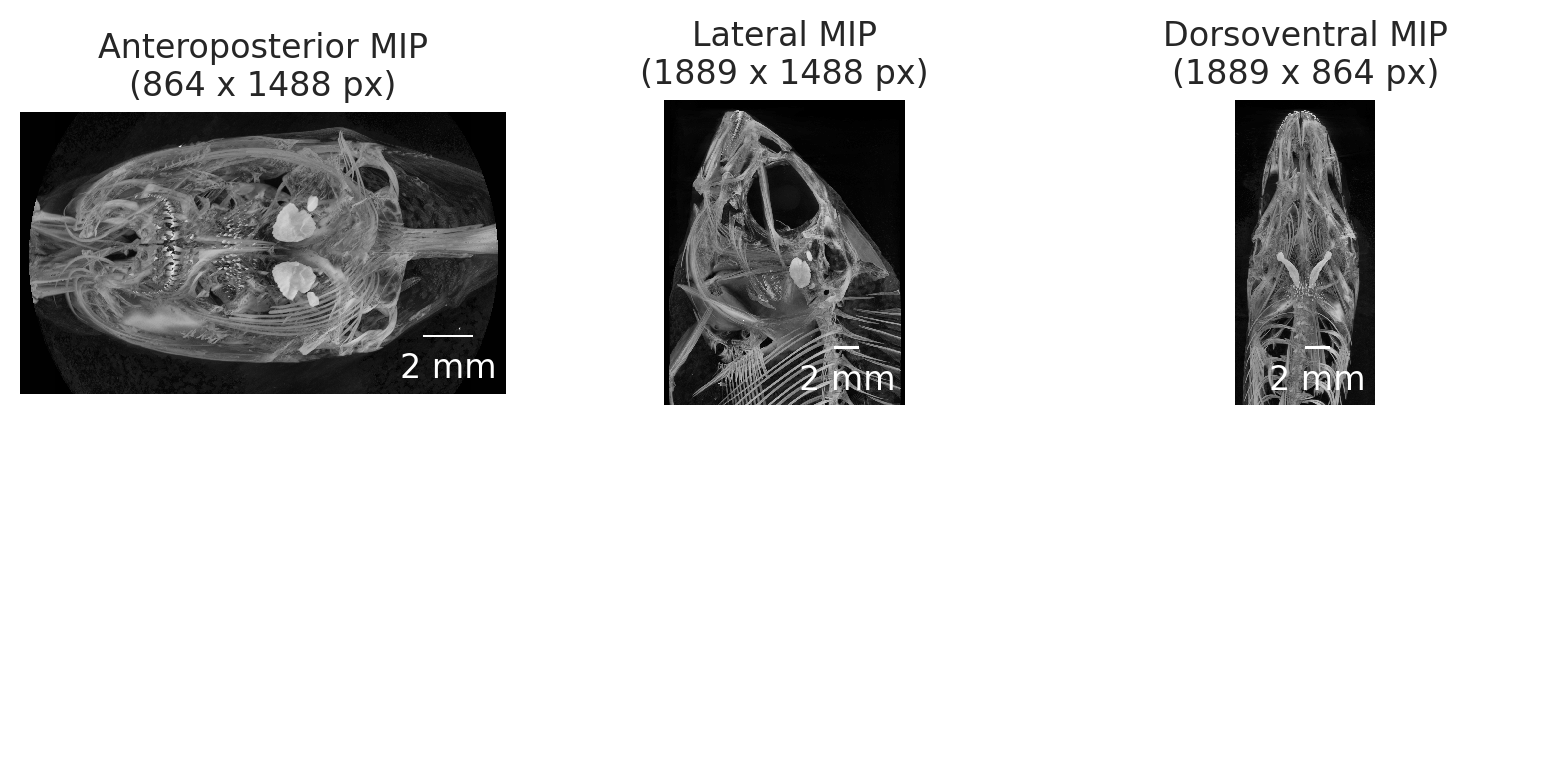

In [42]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 3)
for c, direction in enumerate(directions):
    mip = fig.add_subplot(gs[0, c])
    plt.imshow(skimage.exposure.equalize_adapthist(Data['MIP_' + direction][whichfish]))
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
    plt.title('%s MIP\n(%s x %s px)' % (direction, Data['MIP_' + direction][whichfish].shape[0], Data['MIP_' + direction][whichfish].shape[1]))
    plt.axis('off')
    mip = fig.add_subplot(gs[1, c]) # empty subplots for display reasons
    plt.axis('off')
outfilename = os.path.join('/home/habi/P/Talks/20230904_COMULIS/images/cichlids/',
                           'Otolither_%s_%s_%s.png' % (Data['Fish'][whichfish].split('_')[0], Data['Scan'][whichfish].replace('.rec',''), '01_Overview'))
plt.tight_layout()
plt.savefig(outfilename, transparent=True, bbox_inches='tight')
plt.show()

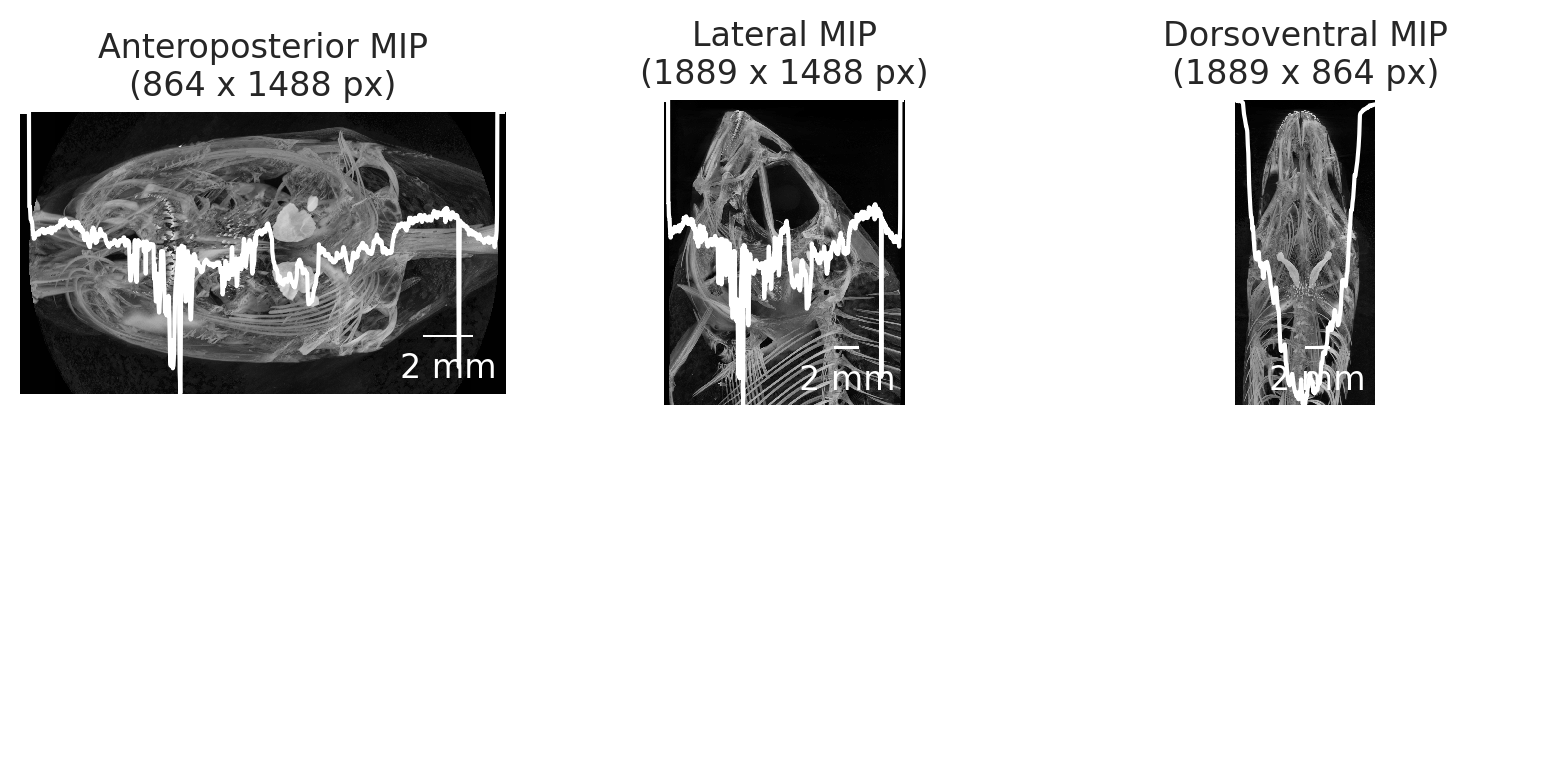

In [43]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 3)
for c, direction in enumerate(directions):
    mip = fig.add_subplot(gs[0, c])
    plt.imshow(skimage.exposure.equalize_adapthist(Data['MIP_' + direction][whichfish]))
    # Plot gray values onto the image
    plt.plot(rescale_linear(Data['Grayvalues_' + direction + '_horizontal'][whichfish], 0, Data['MIP_' + direction][whichfish].shape[0] - 1),
             label='horizontal', color='white')
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
    plt.title('%s MIP\n(%s x %s px)' % (direction, Data['MIP_' + direction][whichfish].shape[0], Data['MIP_' + direction][whichfish].shape[1]))
    plt.axis('off')    
    mip = fig.add_subplot(gs[1, c]) # empty subplots for display reasons
    plt.axis('off')
outfilename = os.path.join('/home/habi/P/Talks/20230904_COMULIS/images/cichlids/',
                           'Otolither_%s_%s_%s.png' % (Data['Fish'][whichfish].split('_')[0], Data['Scan'][whichfish].replace('.rec',''), '02_GrayValues'))
plt.tight_layout()
plt.savefig(outfilename, transparent=True, bbox_inches='tight')
plt.show()

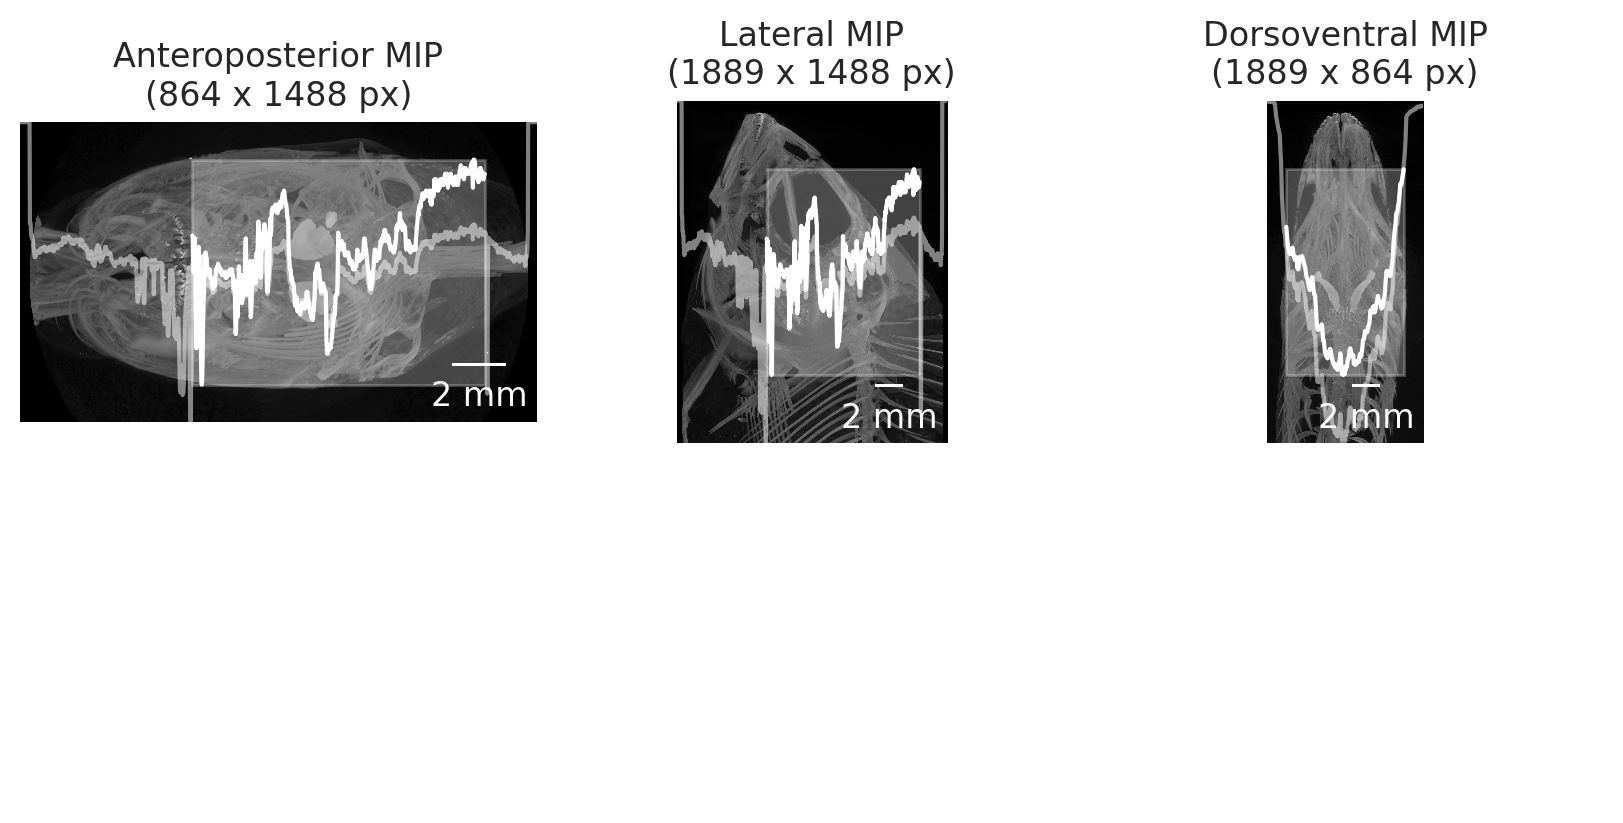

In [44]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 3)
for c, direction in enumerate(directions):
    mip = fig.add_subplot(gs[0, c])
    plt.imshow(skimage.exposure.equalize_adapthist(Data['MIP_' + direction][whichfish]))
    plt.plot(rescale_linear(Data['Grayvalues_' + direction + '_horizontal'][whichfish], 0, Data['MIP_' + direction][whichfish].shape[0] - 1),
             label='horizontal', color='white', alpha=0.5)
    plt.gca().add_patch(matplotlib.patches.Rectangle((Data['Discard_' + direction + '_image_horizontal'][whichfish][0],
                                                      Data['Discard_' + direction + '_image_vertical'][whichfish][0]),
                                                     Data['MIP_' + direction][whichfish].shape[1] - (Data['MIP_' + direction][whichfish].shape[1] - Data['Discard_' + direction + '_image_horizontal'][whichfish][1]) - Data['Discard_' + direction + '_image_horizontal'][whichfish][0],
                                                     Data['MIP_' + direction][whichfish].shape[0] - (Data['MIP_' + direction][whichfish].shape[0] - Data['Discard_' + direction + '_image_vertical'][whichfish][1]) - Data['Discard_' + direction + '_image_vertical'][whichfish][0],
                                                     color='white', alpha=0.25,
                                                     label='Region for detection'))    
    plt.plot(range(Data['Discard_' + direction + '_image_horizontal'][whichfish][0], len(Data['Grayvalues_' + direction + '_horizontal'][whichfish][:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]])),
             rescale_linear(Data['Grayvalues_' + direction + '_horizontal'][whichfish][Data['Discard_' + direction + '_image_horizontal'][whichfish][0]:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]],
                            Data['Discard_' + direction + '_image_vertical'][whichfish][0],
                            Data['Discard_' + direction + '_image_vertical'][whichfish][1]),
             color='white')
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
    plt.title('%s MIP\n(%s x %s px)' % (direction, Data['MIP_' + direction][whichfish].shape[0], Data['MIP_' + direction][whichfish].shape[1]))
    plt.axis('off')
    mip = fig.add_subplot(gs[1, c]) # empty subplots for display reasons
    plt.axis('off')
outfilename = os.path.join('/home/habi/P/Talks/20230904_COMULIS/images/cichlids/',
                           'Otolither_%s_%s_%s.png' % (Data['Fish'][whichfish].split('_')[0], Data['Scan'][whichfish].replace('.rec',''), '03_GrayValuesRegion'))
plt.savefig(outfilename, transparent=True, bbox_inches='tight')
plt.show()

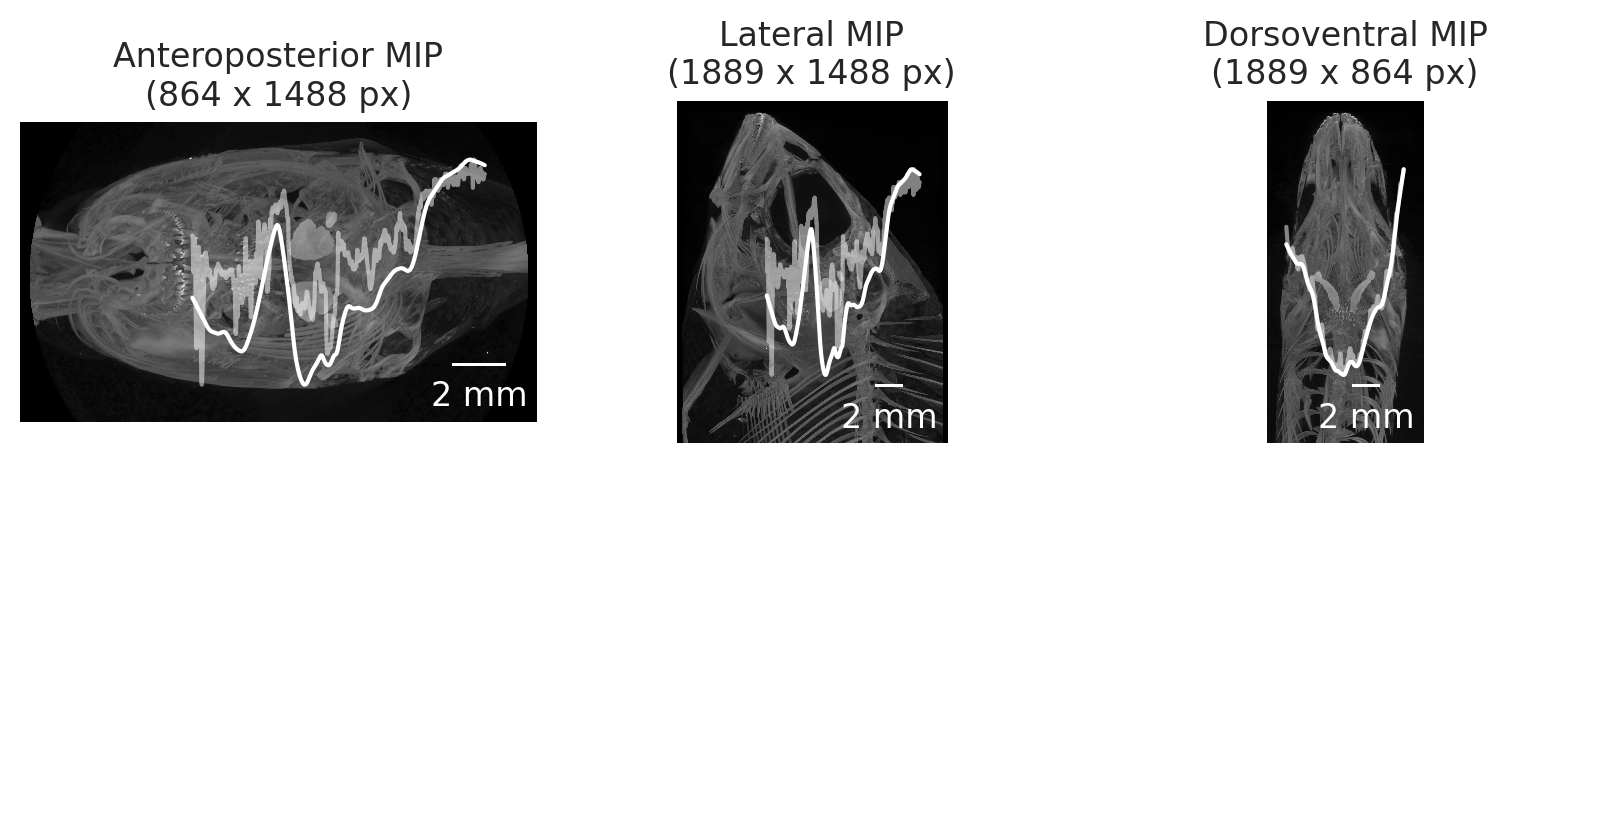

In [45]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 3)
for c, direction in enumerate(directions):
    mip = fig.add_subplot(gs[0, c])
    plt.imshow(skimage.exposure.equalize_adapthist(Data['MIP_' + direction][whichfish]))
    plt.plot(range(Data['Discard_' + direction + '_image_horizontal'][whichfish][0], len(Data['Grayvalues_' + direction + '_horizontal'][whichfish][:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]])),
             rescale_linear(Data['Grayvalues_' + direction + '_horizontal'][whichfish][Data['Discard_' + direction + '_image_horizontal'][whichfish][0]:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]],
                            Data['Discard_' + direction + '_image_vertical'][whichfish][0],
                            Data['Discard_' + direction + '_image_vertical'][whichfish][1]),
             color='white', alpha=0.5)
    plt.plot(range(Data['Discard_' + direction + '_image_horizontal'][whichfish][0], len(Data['Grayvalues_' + direction + '_horizontal'][whichfish][:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]])),
             rescale_linear(smoother(Data['Grayvalues_' + direction + '_horizontal'][whichfish][Data['Discard_' + direction + '_image_horizontal'][whichfish][0]:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]]),
                            Data['Discard_' + direction + '_image_vertical'][whichfish][0],
                            Data['Discard_' + direction + '_image_vertical'][whichfish][1]),
             color='white')
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
    plt.title('%s MIP\n(%s x %s px)' % (direction, Data['MIP_' + direction][whichfish].shape[0], Data['MIP_' + direction][whichfish].shape[1]))
    plt.axis('off')    
    mip = fig.add_subplot(gs[1, c]) # empty subplots for display reasons
    plt.axis('off')
outfilename = os.path.join('/home/habi/P/Talks/20230904_COMULIS/images/cichlids/',
                           'Otolither_%s_%s_%s.png' % (Data['Fish'][whichfish].split('_')[0], Data['Scan'][whichfish].replace('.rec',''), '04_GrayValuesSmoothed'))
plt.savefig(outfilename, transparent=True, bbox_inches='tight')
plt.show()

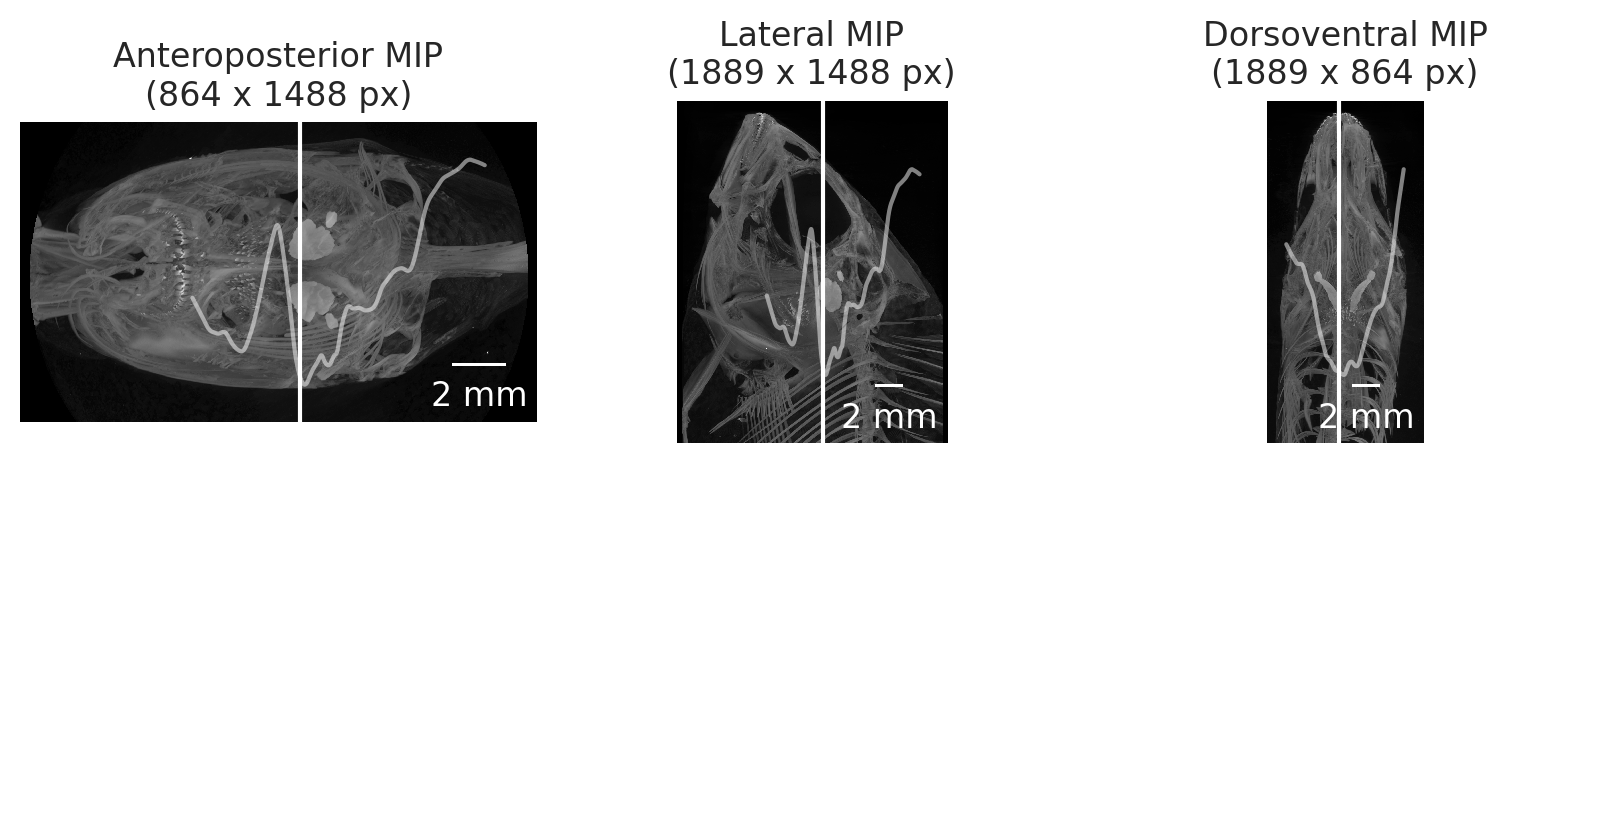

In [46]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 3)
for c, direction in enumerate(directions):
    mip = fig.add_subplot(gs[0, c])
    plt.imshow(skimage.exposure.equalize_adapthist(Data['MIP_' + direction][whichfish]))
    plt.plot(range(Data['Discard_' + direction + '_image_horizontal'][whichfish][0], len(Data['Grayvalues_' + direction + '_horizontal'][whichfish][:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]])),
             rescale_linear(smoother(Data['Grayvalues_' + direction + '_horizontal'][whichfish][Data['Discard_' + direction + '_image_horizontal'][whichfish][0]:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]]),
                            Data['Discard_' + direction + '_image_vertical'][whichfish][0],
                            Data['Discard_' + direction + '_image_vertical'][whichfish][1]),
             color='white', alpha=0.5)
    if 'Ante' in direction:
        plt.axvline(Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                    label='Mean DV @ %s' % Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                    color='white')
    elif 'Late' in direction:
        plt.axvline(Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                    label='Mean DV @ %s' % Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                    color='white')
    else:
        plt.axvline(Data['Otolith_Peak_Lateral_fish'][whichfish],
                    label='Mean LT @ %s' % Data['Otolith_Peak_Lateral_fish'][whichfish],
                    color='white')   
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
    plt.title('%s MIP\n(%s x %s px)' % (direction, Data['MIP_' + direction][whichfish].shape[0], Data['MIP_' + direction][whichfish].shape[1]))
    plt.axis('off')
    mip = fig.add_subplot(gs[1, c])
    plt.axis('off')
outfilename = os.path.join('/home/habi/P/Talks/20230904_COMULIS/images/cichlids/',
                           'Otolither_%s_%s_%s.png' % (Data['Fish'][whichfish].split('_')[0], Data['Scan'][whichfish].replace('.rec',''), '05_Peaks'))
plt.savefig(outfilename, transparent=True, bbox_inches='tight')
plt.show()

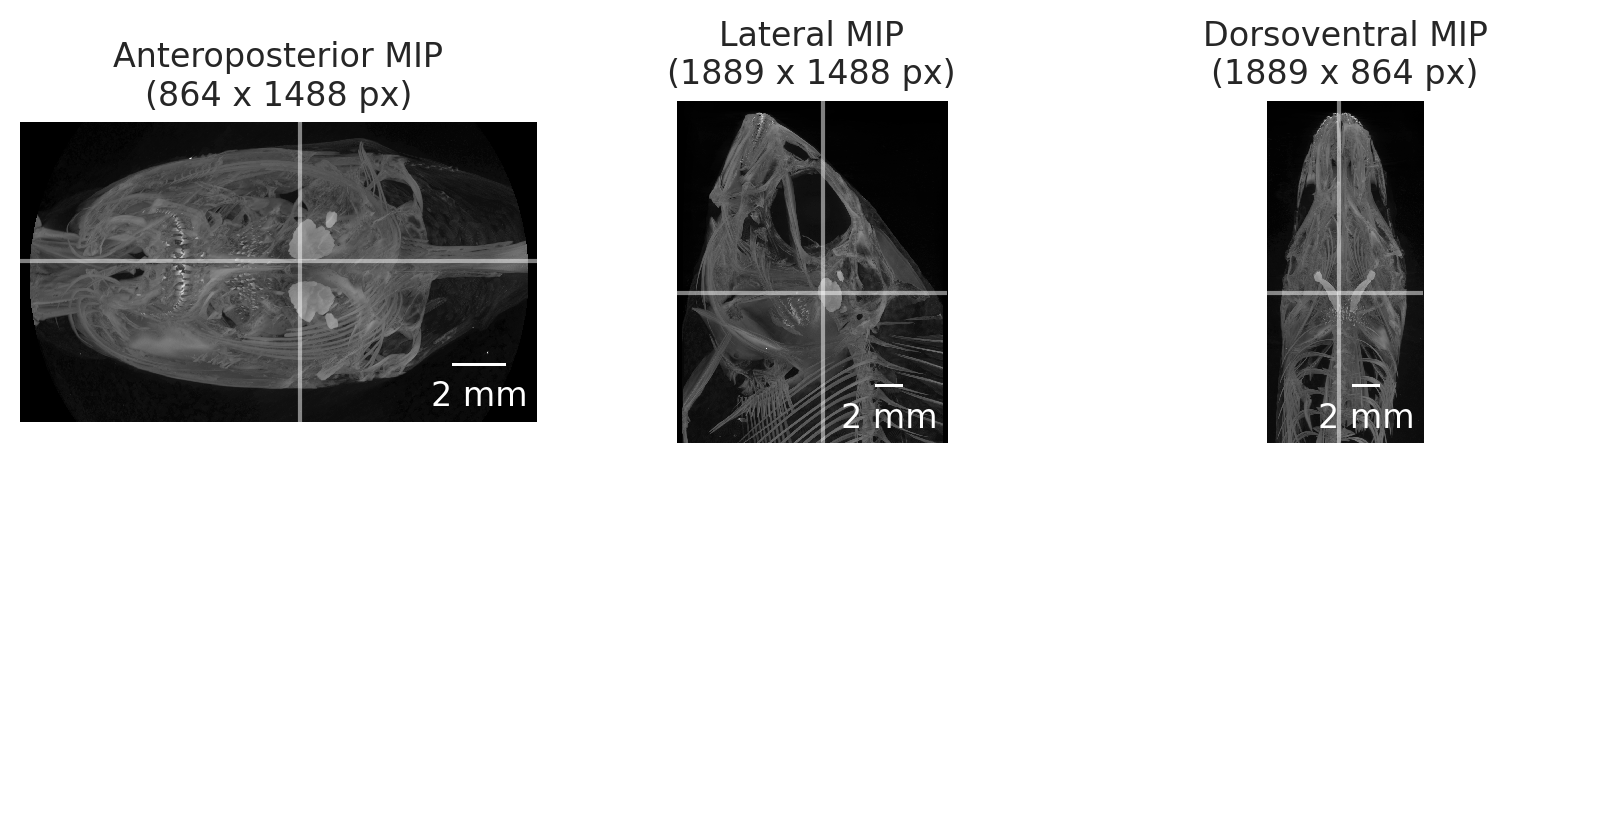

In [47]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 3)
for c, direction in enumerate(directions):
    mip = fig.add_subplot(gs[0, c])
    plt.imshow(skimage.exposure.equalize_adapthist(Data['MIP_' + direction][whichfish]))
    # Show peaks
    if 'Ante' in direction:
        plt.axhline(Data['Otolith_Peak_Lateral_fish'][whichfish],
                    label='Mean LT @ %s' % Data['Otolith_Peak_Lateral_fish'][whichfish],
                    color='white', alpha=0.5)
        plt.axvline(Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                    label='Mean DV @ %s' % Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                    color='white', alpha=0.5)
    elif 'Late' in direction:
        plt.axhline(Data['Otolith_Peak_Anteroposterior_fish'][whichfish],
                    label='Mean AP @ %s' % Data['Otolith_Peak_Anteroposterior_fish'][whichfish],
                    color='white', alpha=0.5)
        plt.axvline(Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                    label='Mean DV @ %s' % Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                    color='white', alpha=0.5)
    else:
        plt.axhline(Data['Otolith_Peak_Anteroposterior_fish'][whichfish],
                    label='Mean AP @ %s' % Data['Otolith_Peak_Anteroposterior_fish'][whichfish],
                    color='white', alpha=0.5)
        plt.axvline(Data['Otolith_Peak_Lateral_fish'][whichfish],
                    label='Mean LT @ %s' % Data['Otolith_Peak_Lateral_fish'][whichfish],
                    color='white', alpha=0.5)
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
    plt.title('%s MIP\n(%s x %s px)' % (direction, Data['MIP_' + direction][whichfish].shape[0], Data['MIP_' + direction][whichfish].shape[1]))
    plt.axis('off')
    mip = fig.add_subplot(gs[1, c])
    plt.axis('off')
outfilename = os.path.join('/home/habi/P/Talks/20230904_COMULIS/images/cichlids/',
                           'Otolither_%s_%s_%s.png' % (Data['Fish'][whichfish].split('_')[0], Data['Scan'][whichfish].replace('.rec',''), '06_Peaks_All'))
plt.savefig(outfilename, transparent=True, bbox_inches='tight')
plt.show()

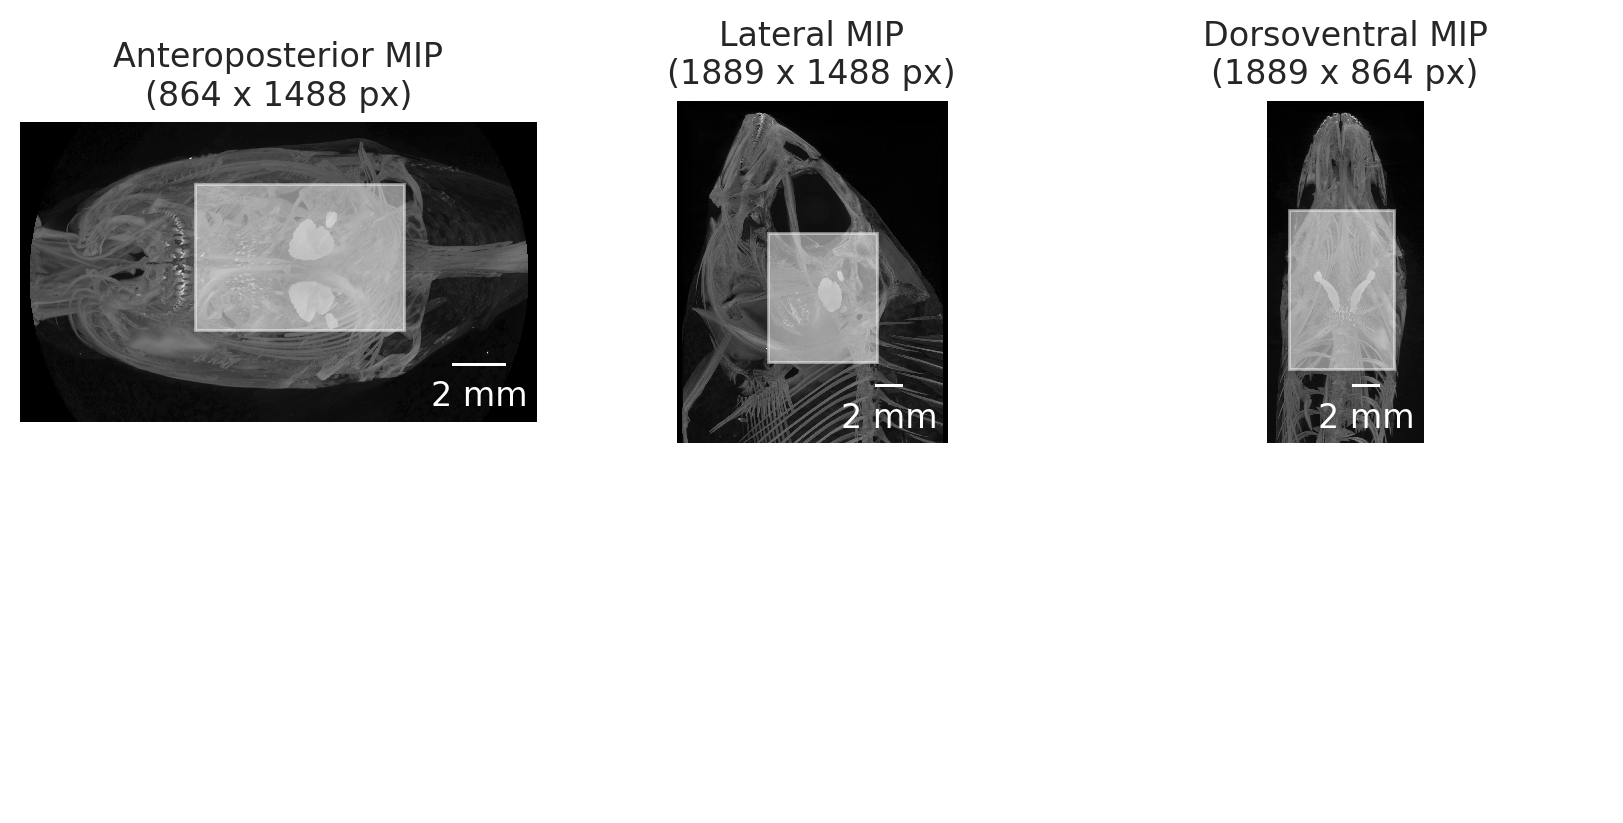

In [48]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 3)
for c, direction in enumerate(directions):
    mip = fig.add_subplot(gs[0, c])
    plt.imshow(skimage.exposure.equalize_adapthist(Data['MIP_' + direction][whichfish]))
    plt.gca().add_patch(matplotlib.patches.Rectangle((Data['Otolith_Peak_' + direction + '_horizontal'][whichfish] - round(Data['Otolith_Width_' + direction + '_horizontal'][whichfish] / 2),
                                                      Data['Otolith_Peak_' + direction + '_vertical'][whichfish] - round(Data['Otolith_Width_' + direction + '_vertical'][whichfish] / 2)),
                                                     Data['Otolith_Width_' + direction + '_horizontal'][whichfish],
                                                     Data['Otolith_Width_' + direction + '_vertical'][whichfish],
                                                     color='white',
                                                     alpha=0.5))
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
    plt.title('%s MIP\n(%s x %s px)' % (direction, Data['MIP_' + direction][whichfish].shape[0], Data['MIP_' + direction][whichfish].shape[1]))
    plt.axis('off')
    mip = fig.add_subplot(gs[1, c])
    plt.axis('off')
outfilename = os.path.join('/home/habi/P/Talks/20230904_COMULIS/images/cichlids/',
                           'Otolither_%s_%s_%s.png' % (Data['Fish'][whichfish].split('_')[0], Data['Scan'][whichfish].replace('.rec',''), '07_ExtractedRegions'))
plt.savefig(outfilename, transparent=True, bbox_inches='tight')
plt.show()

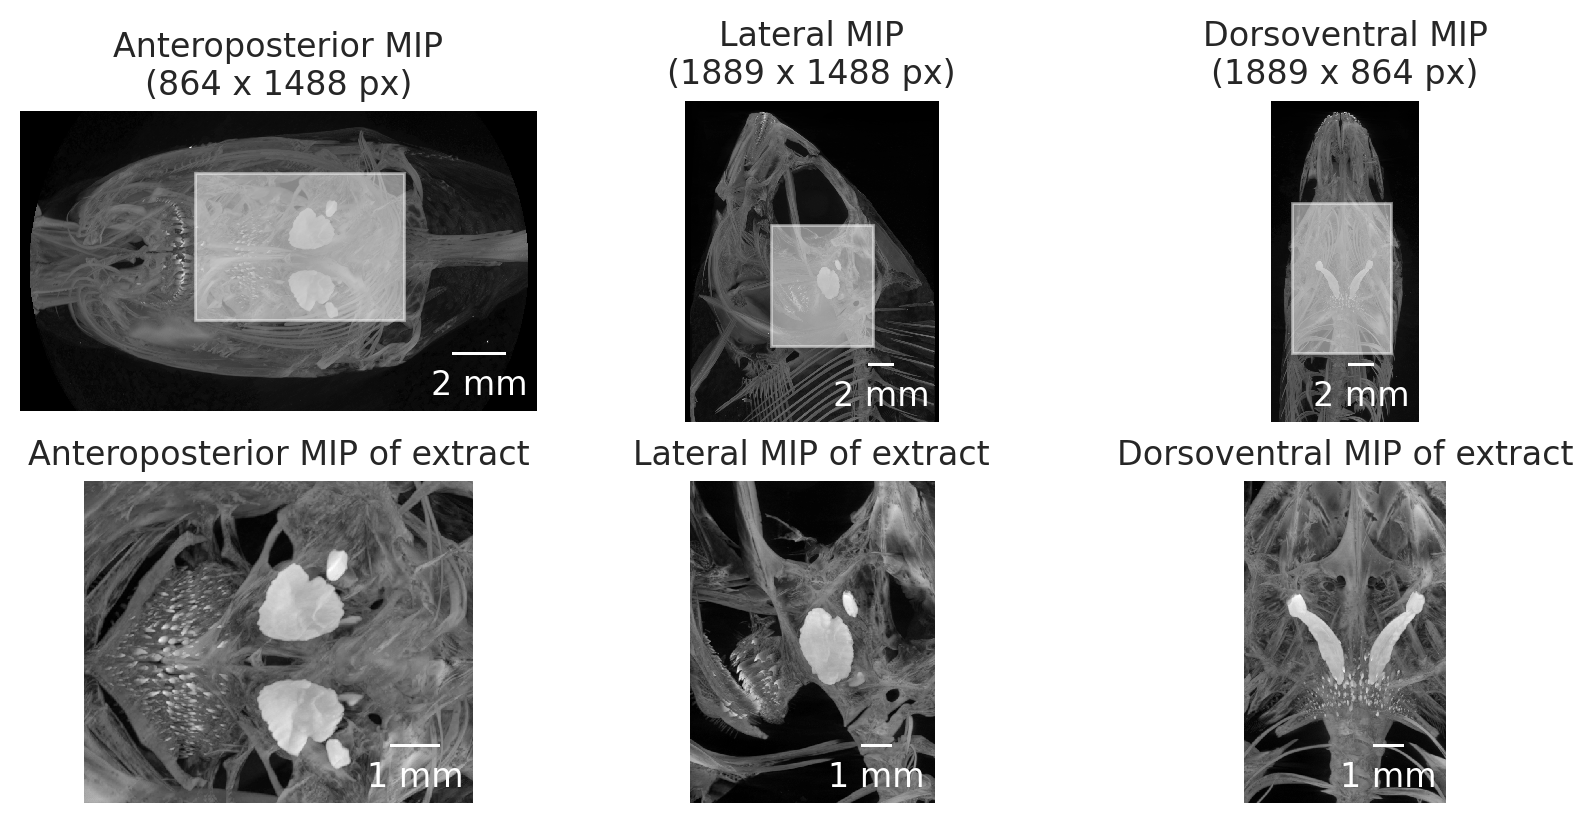

In [49]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 3)
for c, direction in enumerate(directions):
    mip = fig.add_subplot(gs[0, c])
    plt.imshow(skimage.exposure.equalize_adapthist(Data['MIP_' + direction][whichfish]))
    plt.gca().add_patch(matplotlib.patches.Rectangle((Data['Otolith_Peak_' + direction + '_horizontal'][whichfish] - round(Data['Otolith_Width_' + direction + '_horizontal'][whichfish] / 2),
                                                      Data['Otolith_Peak_' + direction + '_vertical'][whichfish] - round(Data['Otolith_Width_' + direction + '_vertical'][whichfish] / 2)),
                                                     Data['Otolith_Width_' + direction + '_horizontal'][whichfish],
                                                     Data['Otolith_Width_' + direction + '_vertical'][whichfish],
                                                     color='white',
                                                     alpha=0.5))
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
    plt.title('%s MIP\n(%s x %s px)' % (direction, Data['MIP_' + direction][whichfish].shape[0], Data['MIP_' + direction][whichfish].shape[1]))
    plt.axis('off')
    mip = fig.add_subplot(gs[1, c])
    OtolithRegion = Reconstructions[whichfish][Data['Otolith_Peak_Anteroposterior_fish'][whichfish] - round(Data['Otolith_Width_Anteroposterior_fish'][whichfish] / 2):
                                                   Data['Otolith_Peak_Anteroposterior_fish'][whichfish] + round(Data['Otolith_Width_Anteroposterior_fish'][whichfish] / 2),
                                                   Data['Otolith_Peak_Lateral_fish'][whichfish] - round(Data['Otolith_Width_Lateral_fish'][whichfish] / 2):
                                                   Data['Otolith_Peak_Lateral_fish'][whichfish] + round(Data['Otolith_Width_Lateral_fish'][whichfish] / 2),
                                                   Data['Otolith_Peak_Dorsoventral_fish'][whichfish] - round(Data['Otolith_Width_Dorsoventral_fish'][whichfish] / 2):
                                                   Data['Otolith_Peak_Dorsoventral_fish'][whichfish] + round(Data['Otolith_Width_Dorsoventral_fish'][whichfish] / 2)].compute()
    plt.imshow(skimage.exposure.equalize_adapthist(OtolithRegion.max(axis=c)))
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
    plt.title('%s MIP of extract' % direction)    
    plt.axis('off')
outfilename = os.path.join('/home/habi/P/Talks/20230904_COMULIS/images/cichlids/',
                           'Otolither_%s_%s_%s.png' % (Data['Fish'][whichfish].split('_')[0], Data['Scan'][whichfish].replace('.rec',''), '08_ExtractedRegionsMIPs'))
plt.savefig(outfilename, transparent=True, bbox_inches='tight')
plt.show()

Now actually extract the otolith from the extract

In [50]:
# Compute histogram and peaks of the extracted otolith
# We need this for segmenting the otolith
histogram, bins = dask.array.histogram(Otoliths[whichfish][Otoliths[whichfish] > 0], bins=2**8, range=(0, 2**8))
peaks = skimage.filters.threshold_multiotsu(Otoliths[whichfish].compute(), classes=5)

In [51]:
def get_largest_regions(segmentation, number_of_regions=4, verbose=False):
    # Get out biggest item from image
    # First iteration based on https://stackoverflow.com/a/55110923/323100
    # Since we want to select the several largest items, we improved on it basedd on
    # https://github.com/numpy/numpy/issues/15128 and
    # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array#comment24252527_6910672
    labels = skimage.measure.label(segmentation)
    # print(numpy.argsort(-numpy.bincount(labels.flat, weights=labels.flat))[:number_of_regions])
    # print(sorted(numpy.bincount(labels.flat, weights=labels.flat), reverse=True)[:number_of_regions])
    # print(numpy.argmax(numpy.bincount(labels.flat, weights=labels.flat)))
    # Initialize empty array to add into
    largestCC = dask.array.zeros_like(segmentation)
    for lbl in numpy.argsort(-numpy.bincount(labels.flat, weights=labels.flat))[:number_of_regions]:
        largestCC += labels == lbl
    if verbose:
        plt.subplot(121)
        plt.imshow(segmentation)
        plt.subplot(122)
        plt.imshow(largestCC)
        plt.suptitle('Largest connected component')
        plt.show()
    return dask.array.rechunk(largestCC.astype('uint8'))

In [52]:
# Get out largest regions
largest = get_largest_regions((Otoliths[whichfish] > peaks[-1]),
                              number_of_regions=4)

In [53]:
# Use the largest regions as masks for the original data
masked_otolith = dask.array.multiply(Otoliths[whichfish], largest)

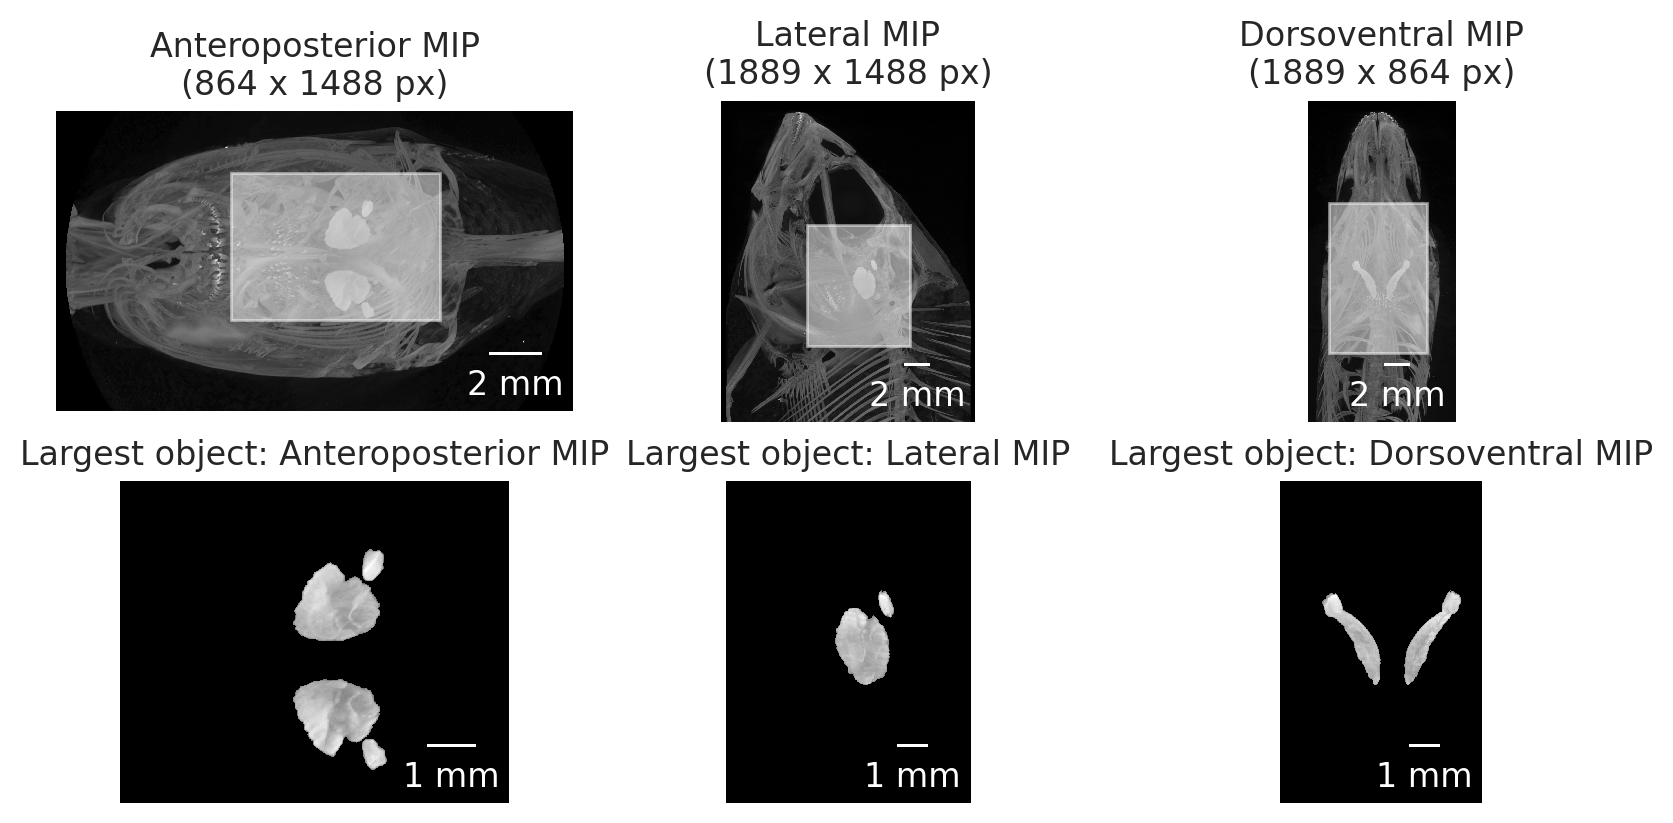

In [63]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 3)
for c, direction in enumerate(directions):
    mip = fig.add_subplot(gs[0, c])
    plt.imshow(Data['MIP_' + direction][whichfish])
    plt.gca().add_patch(matplotlib.patches.Rectangle((Data['Otolith_Peak_' + direction + '_horizontal'][whichfish] - round(Data['Otolith_Width_' + direction + '_horizontal'][whichfish] / 2),
                                                      Data['Otolith_Peak_' + direction + '_vertical'][whichfish] - round(Data['Otolith_Width_' + direction + '_vertical'][whichfish] / 2)),
                                                     Data['Otolith_Width_' + direction + '_horizontal'][whichfish],
                                                     Data['Otolith_Width_' + direction + '_vertical'][whichfish],
                                                     color='white',
                                                     alpha=0.5))
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
    plt.title('%s MIP\n(%s x %s px)' % (direction, Data['MIP_' + direction][whichfish].shape[0], Data['MIP_' + direction][whichfish].shape[1]))
    plt.axis('off')
    mip = fig.add_subplot(gs[1, c])
    plt.imshow(skimage.exposure.equalize_adapthist(masked_otolith.max(axis=c)))    
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um'))
    plt.title('Largest object: %s MIP' % direction)   
    plt.axis('off')
outfilename = os.path.join('/home/habi/P/Talks/20230904_COMULIS/images/cichlids/',
                           'Otolither_%s_%s_%s.png' % (Data['Fish'][whichfish].split('_')[0], Data['Scan'][whichfish].replace('.rec',''), '09_ExtractedOtolithMasked'))
plt.savefig(outfilename, transparent=True, bbox_inches='tight')
plt.show()

In [55]:
def trim_zeros(arr):
    """Returns a trimmed view of an n-D array excluding any outer
    regions which contain only zeros.
    From https://stackoverflow.com/a/65547931/323100
    """
    slices = tuple(slice(idx.min(), idx.max() + 1) for idx in numpy.nonzero(arr))
    return arr[slices]

In [56]:
# Trim the masked data
masked_trimmed = dask.array.asarray(trim_zeros(masked_otolith.compute()))

In [57]:
for s in masked_trimmed.shape:
    print(round(s*Data.Voxelsize[whichfish]/1000,1), 'mm')

3.1 mm
4.5 mm
1.9 mm


View the otolith in 3D

In [58]:
# Display the largestCC of the otolith in 3D
masked_trimmed_volume = k3d.volume(masked_trimmed.astype(numpy.float16),
                                   bounds = [0, Data.Voxelsize[whichfish] * masked_trimmed.shape[0] / 1000,
                                             0, Data.Voxelsize[whichfish] * masked_trimmed.shape[1] / 1000,
                                             0, Data.Voxelsize[whichfish] * masked_trimmed.shape[2] / 1000])
plot = k3d.plot()
plot += masked_trimmed_volume
plot.display()

Output()

In [59]:
# Set nice view above and save camera state
# https://github.com/K3D-tools/K3D-jupyter/issues/417
plot.camera

[]

In [60]:
# Save out HTML page, once in the subdirectory of the fish/scan, and
outputname = os.path.join('/home/habi/P/Talks/20230904_COMULIS/images/cichlids/',
                           'Otolither_%s_%s_%s.html' % (Data['Fish'][whichfish].split('_')[0], Data['Scan'][whichfish].replace('.rec',''), '3D'))
with open(outputname, "w") as f:
    f.write(plot.get_snapshot())
print('3D view saved to %s' % outputname)

3D view saved to /home/habi/P/Talks/20230904_COMULIS/images/cichlids/Otolither_104016_head_3D.html
